# CV Keyword Generator

## NLP - MBDO2 - Team C

Filippo, Almira, Bethany, Tania, Patricio, Maurice


We are building a tool, that generates potential Keywords that should be included in a CV.

The basic assumption is that if we look at a big number of job descriptions, the most common words among all of them are key for this industry and job title. If they are not on your CV, you might want to think about including them.

We start by importing relevant packages for webscraping, NLP, data handling, language detection, and pdf to text conversion.

In [36]:
# webscraping
from bs4 import BeautifulSoup
import urllib.request
import time
import random

# NLP
from nltk.corpus import stopwords
import nltk
from collections import Counter

# Data Handling
import numpy as np
import pandas as pd
import itertools

# Detect Language
from langdetect import detect, detect_langs

# PDF convertor
from pdfminer.pdfparser import PDFParser, PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams, LTTextBox, LTTextLine

# Wordcloud and Visualizations
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Below function creates an indeed url that where some information will be extracted based on the job title and the city.

In [2]:
def get_indeed_url(job_title, city):
    # paste together indeed url
    # called by job_info_indeed
    # city must be in spain
    ## add other countries
    
    # the job title can include spaces which need to be replaced by a '+' in the url
    inter = "+".join(job_title.lower().split(" "))
    
    # to avoid errors, the city value is converted to lowercase
    city = city.lower()
    
    # now, the two parameters can be inserted in the url and the final one is constructed
    url = "https://www.indeed.es/ofertas?q=%22\""+inter+"\"%22&l=\""+city+"\""
    
    # returned is the full URL
    return url

A Dataframe is constructed which includes information about all job descriptions that appear when a user goes to a companies website. The language of that job description is extracted to match the language of the CV. To do that, the above function to create an indeed url is called.

The URL is opened for each page on indeed we want to scrape. Each page contains 10 Job postings with its own url which are converded into text using the function defined after called cleaning(url).

Additional information from Indeed is extracted, such as the company, the job title, the salary and the job link on the companies website. This can be used to display advertisement of jobs to the user, when implemented on a web interface.

In [72]:
def job_info_indeed(job_title, city):
    # scrap job info from indeed
    
    # calls get_indeed_url(job_description, city) function to get an indeed url
    # calls cleaning(url) function to clean the description
    # outputs pandas dataframe with job info, including link to jobs, company name, job title, salary, description based on cleaned text from job descriptions behind those links and language of job description
    
    # placeholder list to fill and finally create a dataframe
    companies = []
    jobs = []
    salaries = []
    descriptions = []
    links = [] 
    languages = []
    
    # a certain amount of pages on indeed are opened. each one contains 10 descriptions
    for page in range(5):
        
        # get the url from the created function
        url = get_indeed_url(job_title, city)
        
        # we add the number of the page we want to access
        url = url+"&start="+str(page)
        
        # we open the site and get a html file back
        try:
            site = urllib.request.urlopen(url).read()  
        except:
            return
        
        # html file is parsed to extract the data
        soup_obj = BeautifulSoup(site, "html.parser")
        
        # we only want to see data of organic search results. Featured results might be for other job titles
        results = soup_obj.find_all('div', attrs={'data-tn-component': 'organicJob'})  

        # for every job listing, we extract relevant information and fill the respective placeholder list
        for x in results:
            
            # get company name
            company = x.find('span', attrs={"itemprop":"name"})
            companies.append(company.text.strip())
            
            # get job title
            job = x.find('a', attrs={'data-tn-element': "jobTitle"})
            jobs.append(job.text.strip())
            
            # get job URL
            url = "https://www.indeed.es"+job['href']
            links.append(url)
            
            # get description with helper function cleaning(url)
            desc = cleaning(url)
            
            # get description language
            if desc is None:
                languages.append('N/A')
                descriptions.append('N/A')
            else:
                descriptions.append(desc)
                string = ' '.join(desc)
                languages.append(detect(string))
            
            # get salary
            salary = x.find('nobr')
            if salary:
                salaries.append(salary.text.strip())
            else:
                salaries.append('N/A')
            
            # we don't want indeed to get opset about us scraping them programmatically.
            # The function pauses a random amount of time before accessing each link and page.
            time.sleep(random.uniform(0.4,2.8))
        time.sleep(random.uniform(0.5,1.1))
    
    # if we are not able to access the company website with the job description, we replace with 'N/A'
    descriptions = [['N/A'] if desc is None else desc for desc in descriptions]
    
    # constructing a list to convert to a dataframe
    data = [('Company', companies), ('Job Title', jobs), ('Salary', salaries), ('Link', links), ('Description', descriptions), ('Language', languages)]
    
    # constructing the dataframe
    df = pd.DataFrame.from_items(data)
    
    # returned is the full dataframe with job info, including link to jobs, company name, job title, salary, description based on cleaned text from job descriptions behind those links and language of job description
    return df

To extract relevant information of a companie's job portal, below function is used to clean the text. Input is the website to the job listing and ouput is list of cleaned words.

In [4]:
def cleaning(website):
    # cleaning company website with job description
    # called by top_keywords
    # output list with words in job description
    
    # the job listing is opened
    try:
        site = urllib.request.urlopen(website).read()
    except:
        return
    
    # parsing the html file
    soup_obj = BeautifulSoup(site, "html.parser") 

    # we remove unrelevant tags and special characters in html
    for line in soup_obj(["style","script"]):
        line.extract()

    # we extract the text and convert it to lower case
    text = soup_obj.get_text().lower()

    # get rid of the line breaks
    line_text = text.splitlines()

    # remove empty values
    line_split = [line for line in line_text if line != None]

    # we sort the words based on their lenght
    line_sorted = sorted(line_split, key = len, reverse = True)

    # we create a list with all the words combined in a string
    clean = [line.split(" ") for line in line_sorted]

    # now we flatten this list to have all the values in one list without nested lists
    unlist = [item for sublist in clean for item in sublist]

    # using NLTK, we extract stopwords
    stop_english = set(stopwords.words("english"))
    stop_spanish = set(stopwords.words("spanish"))

    # finally, we remove all the stopwords, those won't be relevant for our analysis
    clean_lines = [line for line in unlist if not line in stop_english and not line in stop_spanish] 

    # returned is a clean list with all the relevant words
    return clean_lines

Now that we have clean text, we extract the most common words from all the job descriptions combined.

The following function used the above mentioned functions to get a dataframe with all the relevant information and generates a list of most common words.


In [5]:
def top_keywords(job_title, city, language):
    # calls cleaning(website) function
    # city -> needs to be a Spanish city
    # language -> only two options: 'en' or 'es'
    # calls job_info_indeed(job_title, city)
    # output list of most common keywords
    
    # the function that creates the dataframe is called
    indeeddf = job_info_indeed(job_title, city)
    
    # we only need the job descriptions that have a language equal to the cv's language
    descriptions = indeeddf['Description'][indeeddf['Language'] == language]
    
    # placeholder list to fill in
    wordds = []
    
    # all the descriptions are combined into one list
    for i in descriptions:
        wordds.append(i)
    
    # clean out blank values
    wordds = list(filter(None, wordds))
    
    # we don't want lists in the list. One list with all the words is used to clean
    wordds = list(itertools.chain.from_iterable(wordds))
    wordds = list(filter(None, wordds))
    
    # count each word
    topvalues = Counter(wordds)
    
    # get most common words that appear in the list
    topvalues = topvalues.most_common(50)
    
    # remove special characters
    topvalues = [i for i in topvalues if i[0].isalnum()]
    
    # returned is a list of potential keywords
    return topvalues

To read the text from a cv in pdf format and detect its language, below function is used.

In [12]:
def pdf_to_text(cv_filename):
    # cv_filename as string path to file
    # output text as a list of strings

    # we open the file
    cv = open(cv_filename, 'rb')
    
    # We conver the PDF to a list of strings containing the content as text
    parser = PDFParser(cv)
    pdfdoc = PDFDocument()
    parser.set_document(pdfdoc)
    pdfdoc.set_parser(parser)
    pdfdoc.initialize('')
    rsrcmgr = PDFResourceManager()
    laparams = LAParams()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    text = []
    
    # we process each page in the document. CVs should mainly have only one page
    for page in pdfdoc.get_pages():
        interpreter.process_page(page)
        layout = device.get_result()
        for lt_obj in layout:
            if isinstance(lt_obj, LTTextBox) or isinstance(lt_obj, LTTextLine):
                text.append(lt_obj.get_text())
    
    # we replace line breaks
    final_text = []            
    for string in text:
        string = string.replace("\n","")
        final_text.append(string)
    
    # now, the language of the cv is detedted and the text converted to lower case
    final_text = " ".join(final_text)
    language = detect(final_text)
    final_text = final_text.split()
    final_text = [x.lower() for x in final_text]
    
    # output is the text from the CV and the language
    return final_text , language

Finally, we combine the functions and compare the keywords from all job descriptions to the text from the CV.

Each Keyword that was common in job descriptions but is not in the CV is returned.

In [87]:
def rate_cv(cv_filename, job_title, city):
    # calls pdf_to_text
    # calls top_keywords
    
    # get CV text and language
    cv_text, cv_language = pdf_to_text(cv_filename)
    
    # get Keywords based on language
    suspects = top_keywords(job_title, city, cv_language)
    
    # extract keyword from tuple with weight
    keywords = [x[0] for x in suspects]
    
    # negative keywords
    blacklist = ['search','us','ebay','help','islands','job','jobs','new','press','company', 'mckinsey', 'page', 'home', 'linkedin', 'apply', city.lower(), 'sign', 'email', 'products', 'share', 'careers', 'services', 'global', 'clients', '1', 'media', 'gas', 'information', 'featured', 'sector', 'toggle', 'accenture', 'alstom', 'please', 'join', 'morgan', 'jpmorgan', 'city', 'click', 'view', 'sheng']
    
    # compare Keywords to words in CV and blacklist
    not_in_cv = [x for x in keywords if x not in cv_text and x not in blacklist]
    
    # we return a list of Keywords that should be checked to include in the CV
    return not_in_cv, suspects

In [86]:
def CV_Keywords(cv_filename, job_title, city):
    # calls rate_cv
   
    not_in_cv, suspects = rate_cv(cv_filename, job_title, city)
    
    words = [i for i in suspects if i[0] in not_in_cv]

    words = [(i[0]+ ' ') *i[1] for i in words]

    words = [string.split() for string in words]

    words = [' '.join(word) for word in words]

    words = ' '.join(words)

    wc = WordCloud(max_words=len(words), margin=4, random_state=13).generate(words)

    plt.figure(figsize=(15,10), dpi=240)
    plt.title("CV Keywords")
    plt.imshow(wc.to_array())
               #, interpolation="bilinear")
    plt.axis("off")
    
    result = plt.show()
    
    return result

As it can be observed below, a useful List of potential Keywords is generated. Maurice will need to polish his CV if he wants to get a job!

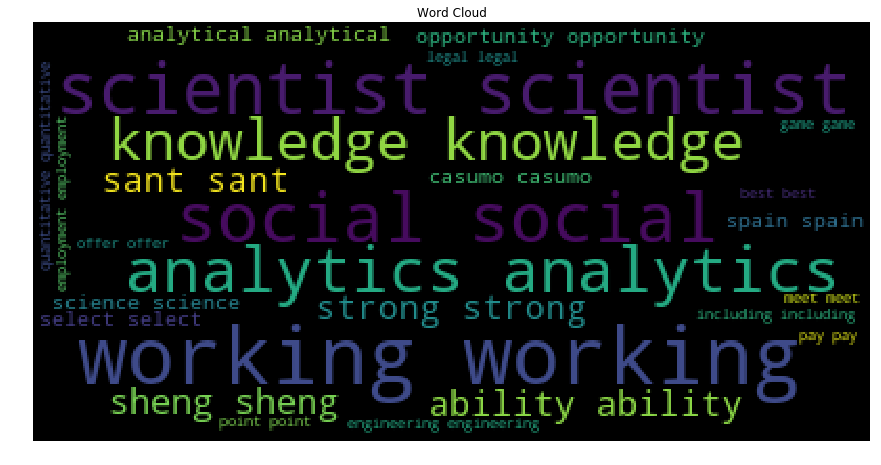

In [85]:
CV_Keywords('Maurice Schoepf - Junior Data Scientist - EY.pdf', 'Data Scientist', 'Barcelona')

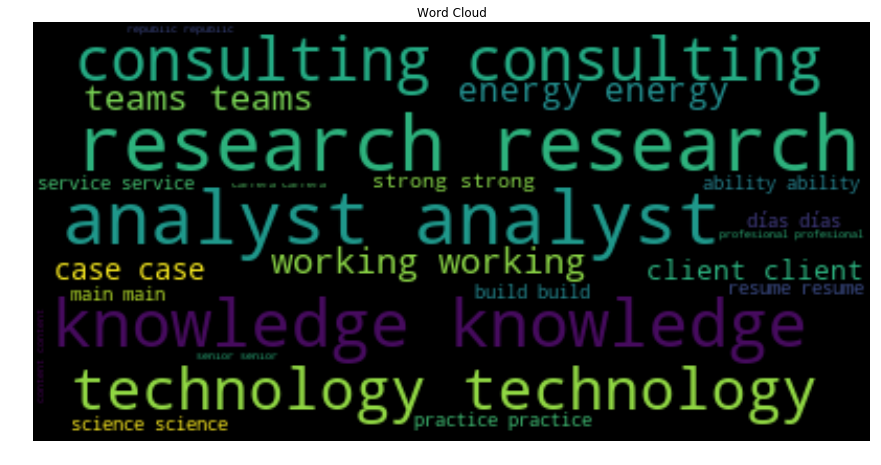

In [74]:
CV_Keywords('Maurice Schoepf - Junior Data Scientist - EY.pdf', 'Data Analyst', 'Madrid')

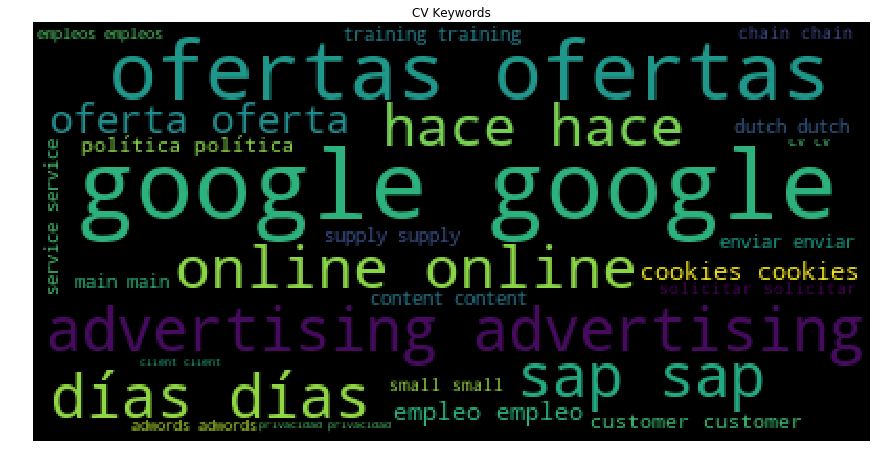

In [88]:
CV_Keywords('Maurice Schoepf - Junior Data Scientist - EY.pdf', 'BI Consultant', 'Barcelona')

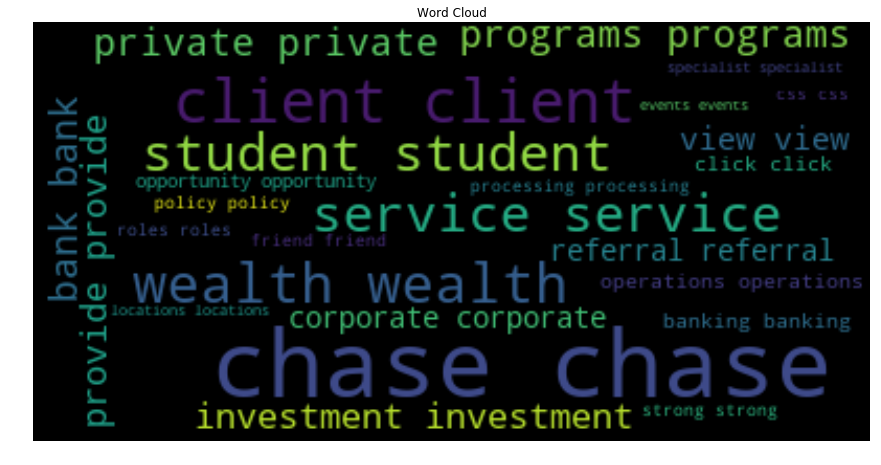

In [82]:
CV_Keywords('Maurice Schoepf - Junior Data Scientist - EY.pdf', 'Investment Banker', 'Madrid')